In [2]:
import pandas as pd
import numpy as np
import scipy
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf

In [3]:
btc_data = pd.read_csv("../../data/BTCUSDT3600.csv")
btc_data["date"] = btc_data["date"].astype("datetime64[s]")
btc_data = btc_data.set_index("date")
btc_data = btc_data.dropna()
btc_data.head(3)

,open,high,low,close,volume
date,,,,,
2018-01-01 01:00:00,13527.841167,13595.259915,13153.294540,13203.699294,384.940892
2018-01-01 02:00:00,13203.567250,13419.331793,13199.152380,13331.250914,429.888403
2018-01-01 03:00:00,13332.298878,13612.086569,13288.738587,13408.246493,421.922265


In [4]:
eth_data = pd.read_csv("../../data/ETHUSDT3600.csv")
eth_data["date"] = eth_data["date"].astype("datetime64[s]")
eth_data = eth_data.set_index("date")
eth_data = eth_data.dropna()
eth_data.head(3)

,open,high,low,close,volume
date,,,,,
2018-01-01 01:00:00,727.029312,731.987082,716.852963,718.015406,2320.961658
2018-01-01 02:00:00,717.704599,725.801211,717.624823,724.105981,2172.553573
2018-01-01 03:00:00,723.950227,738.017332,722.596765,734.479535,2170.776746


In [14]:
eth_data["diff"] = np.log(eth_data["close"]).diff()
btc_data["diff"] = np.log(btc_data["close"]).diff()
eth_data.head(5)

,open,high,low,close,volume,diff,next_return
date,,,,,,,
2018-01-01 01:00:00,727.029312,731.987082,716.852963,718.015406,2320.961658,NaN,0.008447
2018-01-01 02:00:00,717.704599,725.801211,717.624823,724.105981,2172.553573,0.008447,0.014224
2018-01-01 03:00:00,723.950227,738.017332,722.596765,734.479535,2170.776746,0.014224,0.013976
2018-01-01 04:00:00,734.967702,744.975621,729.936353,744.816336,2345.819307,0.013976,0.005587
2018-01-01 05:00:00,744.779836,749.998738,742.080404,748.988951,2289.674144,0.005587,0.017442


Correlation 0.8394840622823698


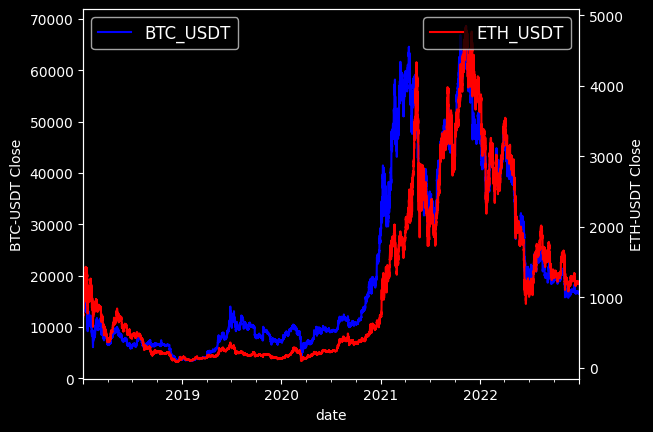

In [6]:
plt.style.use("dark_background")
# Plot cumulative sum of log returns for both btc and eth.
ax = plt.gca()
btc_data["close"].plot(color="blue", label="BTC_USDT", ax=ax)
ax2 = plt.twinx()
eth_data["close"].plot(color="red", label="ETH_USDT", ax=ax2)
ax.legend(loc="upper left", fontsize="large")
ax2.legend(loc="upper right", fontsize="large")
ax.set_ylabel("BTC-USDT Close")
ax2.set_ylabel("ETH-USDT Close")
print("Correlation", eth_data["diff"].corr(btc_data["diff"]))
plt.show()

In [35]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data["close"].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0:  # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0 and last_sig != -1.0:  # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        if signal[i] == 0.0 and last_sig == -1.0:  # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0 and last_sig == 1.0:  # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(
        long_trades, columns=["entry_time", "entry_price", "exit_time", "exit_price"]
    )
    short_trades = pd.DataFrame(
        short_trades, columns=["entry_time", "entry_price", "exit_time", "exit_price"]
    )

    long_trades["return"] = (
        long_trades["exit_price"] - long_trades["entry_price"]
    ) / long_trades["entry_price"]
    short_trades["return"] = (
        -1
        * (short_trades["exit_price"] - short_trades["entry_price"])
        / short_trades["entry_price"]
    )
    long_trades = long_trades.set_index("entry_time")
    short_trades = short_trades.set_index("entry_time")

    long_trades["type"] = 1
    short_trades["type"] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()

    return long_trades, short_trades, all_trades

In [9]:
def cmma(ohlc: pd.DataFrame, lookback: int, atr_lookback: int = 168):
    # cmma = Close minus moving average
    atr = ta.atr(ohlc["high"], ohlc["low"], ohlc["close"], atr_lookback)
    ma = ohlc["close"].rolling(lookback).mean()
    ind = (ohlc["close"] - ma) / (atr * lookback**0.5)
    return ind

In [21]:
def threshold_revert_signal(ind: pd.Series, threshold: float):
    # Outputs a 1 or -1 signal once the indicator goes above threshold or below -threshold
    # Outputs 0 again once the indicator returns to 0

    signal = np.zeros(len(ind))
    position = 0
    for i in range(len(ind)):
        if ind.iloc[i] > threshold:
            position = 1
        if ind.iloc[i] < -threshold:
            position = -1

        if position == 1 and ind.iloc[i] <= 0:
            position = 0

        if position == -1 and ind.iloc[i] >= 0:
            position = 0

        signal[i] = position

    return signal

Profit factor 1.0838262536546437


Text(0, 0.5, 'Cumulative Log Return')

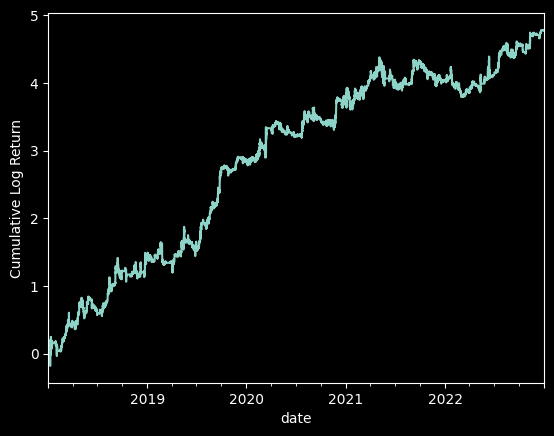

In [29]:
eth_data["next_return"] = eth_data["diff"].shift(-1)
btc_data["next_return"] = btc_data["diff"].shift(-1)


lookback = 24
threshold = 0.25
atr_lookback = 168
btc_cmma = cmma(btc_data, lookback, atr_lookback)
eth_cmma = cmma(eth_data, lookback, atr_lookback)

intermarket_diff = eth_cmma - btc_cmma

eth_data["sig"] = threshold_revert_signal(intermarket_diff, threshold)

plt.style.use("dark_background")
rets = eth_data["sig"] * eth_data["next_return"]
pf = rets[rets > 0].sum() / rets[rets < 0].abs().sum()
print("Profit factor", pf)
rets.cumsum().plot()
plt.ylabel("Cumulative Log Return")

In [36]:
long_trades, short_trades, all_trades = get_trades_from_signal(
    eth_data, eth_data["sig"]
)

long_tr = long_trades["return"]
short_tr = short_trades["return"]

print("long trades")
print("# of trades", len(long_tr))
print("win rate", len(long_tr[long_tr > 0]) / len(long_tr))
print("avg trade %", long_tr.mean() * 100)
print("")
print("short trades")
print("# of trades", len(short_tr))
print("win rate", len(short_tr[short_tr > 0]) / len(short_tr))
print("avg trade %", short_tr.mean() * 100)

/tmp/ipykernel_132492/2088988160.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signal[i] == 1.0 and last_sig != 1.0:  # Long entry
/tmp/ipykernel_132492/2088988160.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signal[i] == -1.0 and last_sig != -1.0:  # Short entry
/tmp/ipykernel_132492/2088988160.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if signal[i] == 0.0 and last_sig == -1.0:  # Short exit
/tmp/ipyk

long trades
# of trades 388
win rate 0.5128865979381443
avg trade % 0.5819315538027854

short trades
# of trades 372
win rate 0.5188172043010753
avg trade % 0.6888949981048935


6 0.05 1.0486696907753108
6 0.07500000000000001 1.0434622506897104
6 0.1 1.0354951575405253
6 0.125 1.0368993516437086
6 0.15000000000000002 1.04843628470307
6 0.175 1.0486798775062112
6 0.2 1.0495118040331557
6 0.22500000000000003 1.0445228009033012
6 0.25 1.055370792464643
6 0.275 1.0528148211912371
6 0.3 1.0369836327821964
6 0.325 1.035321189852441
6 0.35000000000000003 1.0303026261089123
6 0.375 1.030327258815136
6 0.4 1.0311474770849822
6 0.425 1.0398727956086604
6 0.45 1.0246027076167235
6 0.47500000000000003 1.0171968075788838
6 0.5 0.997739619297881
9 0.05 1.0421426963840656
9 0.07500000000000001 1.0441362518617747
9 0.1 1.057987470459785
9 0.125 1.0534866306514934
9 0.15000000000000002 1.0589393305674335
9 0.175 1.0629542042368623
9 0.2 1.055598177825468
9 0.22500000000000003 1.0724619532187216
9 0.25 1.0705454064484994
9 0.275 1.0666330406492108
9 0.3 1.0730459062598037
9 0.325 1.0656616041837443
9 0.35000000000000003 1.0556095148859908
9 0.375 1.0529338722958481
9 0.4 1.0645

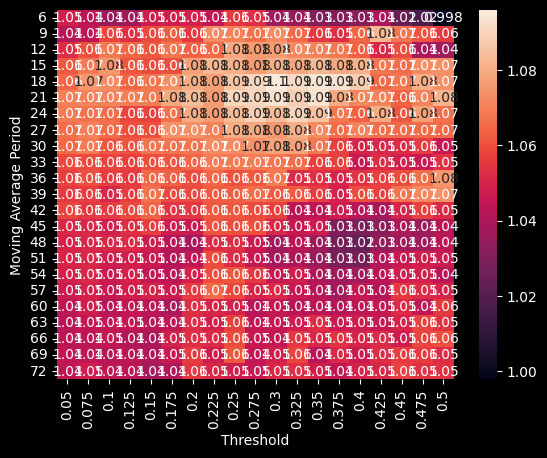

In [37]:
pf_df = pd.DataFrame()
for lookback in range(6, 73, 3):
    for threshold in np.linspace(0.05, 0.5, 19):
        atr_lookback = 168
        btc_cmma = cmma(btc_data, lookback, atr_lookback)
        eth_cmma = cmma(eth_data, lookback, atr_lookback)

        intermarket_diff = eth_cmma - btc_cmma

        eth_data["sig"] = threshold_revert_signal(intermarket_diff, threshold)

        rets = eth_data["sig"] * eth_data["next_return"]

        pf = rets[rets > 0].sum() / rets[rets < 0].abs().sum()
        print(lookback, threshold, pf)
        pf_df.loc[lookback, round(threshold, 3)] = pf

plt.style.use("dark_background")
import seaborn as sns

sns.heatmap(pf_df, annot=True, fmt="0.3g")
plt.xlabel("Threshold")
plt.ylabel("Moving Average Period")
plt.show()